# Fast Agent - Build a SQL Agent fast!

<img src="./assets/LC_L1_top.png" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [2]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env(".env")  # check environmental variables
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # check packages

LANGSMITH_API_KEY=****3d99
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
LANGSMITH_ENDPOINT=****.com
GOOGLE_API_KEY=****zZa4
Python 3.13.7 satisfies requires-python: >=3.11,<3.14
package                | required | installed | status | path                                                                            
---------------------- | -------- | --------- | ------ | --------------------------------------------------------------------------------
langgraph              | >=1.0.0  | 1.0.1     | ✅ OK   | …in_academy/lca-langchainV1-essentials/python/.venv/lib/python3.13/site-packages
langchain              | >=1.0.0  | 1.0.2     | ✅ OK   | …in_academy/lca-langchainV1-essentials/python/.venv/lib/python3.13/site-packages
langchain-core         | >=1.0.0  | 1.0.1     | ✅ OK   | …in_academy/lca-langchainV1-essentials/python/.venv/lib/python3.13/site-packages
langchain-openai       | >=1.0.0  | 1.0.1     | ✅ OK   | …in_academy/lca-langchainV1-essentials/python/.venv/lib/python3.13/sit

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [4]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [5]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [6]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list. 

In [9]:
from langchain.agents import create_agent

agent = create_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
).with_config({"recursion_limit": 50})

Here's a display of the agent ReAct Loop.

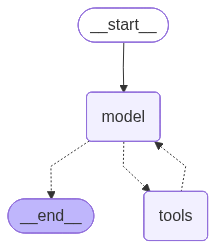

In [7]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [10]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (93c2d824-90e0-4f0e-b2e5-bc249b7ea475)
 Call ID: 93c2d824-90e0-4f0e-b2e5-bc249b7ea475
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (e122e6e8-3d4c-45eb-8523-bf3eac1ff94f)
 Call ID: e122e6e8-3d4c-45eb-8523-bf3eac1ff94f
  Args:
    query: SELECT COUNT(*) FROM Album;
================================= Tool Message =================================
Name: execute_sql

[(347

In [11]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (7fb5d606-88b3-4e54-8252-6cb8d039b48e)
 Call ID: 7fb5d606-88b3-4e54-8252-6cb8d039b48e
  Args:
    query: SELECT T2.Name, AVG(T1.Milliseconds) AS AverageTrackLength FROM tracks AS T1 INNER JOIN genres AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT T2.Name, AVG(T1.Milliseconds) AS AverageTrackLength FROM tracks AS T1 INNER JOIN genres AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message =================

In [12]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (e0a55a0f-6582-44ce-ad83-69cd15d410e5)
 Call ID: e0a55a0f-6582-44ce-ad83-69cd15d410e5
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

The tables are: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track.


**Create your own query here!**  Add some questions of your own.

In [13]:
question = "Summarize the purpose of this database"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Summarize the purpose of this database
================================== Ai Message ==================================
Tool Calls:
  execute_sql (4d084de4-0dc8-43f8-84bf-5f29ab4243aa)
 Call ID: 4d084de4-0dc8-43f8-84bf-5f29ab4243aa
  Args:
    query: SELECT sql FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('CREATE TABLE [Album]\n(\n    [AlbumId] INTEGER  NOT NULL,\n    [Title] NVARCHAR(160)  NOT NULL,\n    [ArtistId] INTEGER  NOT NULL,\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)',), ('CREATE TABLE [Artist]\n(\n    [ArtistId] INTEGER  NOT NULL,\n    [Name] NVARCHAR(120),\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\n)',), ('CREATE TABLE [Customer]\n(\n    [CustomerId] INTEGER  NOT NULL

### Let's try this Studio